## Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

import csv

In [0]:
vocab_size = 1000 #1000, 3000
embedding_dim = 8 #16, 32
max_length = 200 #120
trunc_type='post'
padding_type='pre'
oov_tok = "<OOV>"
training_portion = .8

## Get Data

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv \
    -O bbc-text.csv

--2020-04-01 07:23:39--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/bbc-text.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c02::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5057493 (4.8M) [application/octet-stream]
Saving to: ‘bbc-text.csv’

bbc-text.csv        100%[===================>]   4.82M  19.3MB/s    in 0.2s    

2020-04-01 07:23:40 (19.3 MB/s) - ‘bbc-text.csv’ saved [5057493/5057493]



In [4]:
sentences = []
labels = []
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "how", "how's", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "what", "what's", "when", "when's", "where", "where's", "which", "while", "who", "who's", "whom", "why", "why's", "with", "would", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves" ]
print("total stopwords:", len(stopwords))

with open("bbc-text.csv", 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        labels.append(row[0])
        sentence = row[1]
        for word in stopwords:
            token = " " + word + " "
            sentence = sentence.replace(token, " ")
        sentences.append(sentence)

total_sentence = len(sentences)
print("total labels:", len(labels))
print("total sentences:", total_sentence)
print("one example:", sentences[0])

total stopwords: 153
total labels: 2225
total sentences: 2225
one example: tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abidin

In [5]:
train_size = int(len(sentences) * training_portion)

train_sentences = sentences[:train_size]
train_labels = labels[:train_size]

validation_sentences = sentences[train_size:]
validation_labels = labels[train_size:]

print(train_size)
print(len(train_sentences))
print(len(train_labels))
print(len(validation_sentences))
print(len(validation_labels))

1780
1780
1780
445
445


## Tokenize and pad the sentences

In [0]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

#print(word_index)

In [10]:
train_sequences = tokenizer.texts_to_matrix(train_sentences, mode='binary')

print(train_sequences.shape)
#print(train_sequences[0])

(1780, 1000)


In [11]:
validation_sequences = tokenizer.texts_to_matrix(validation_sentences, mode='binary')

print(validation_sequences.shape)
#print(validation_sequences[0])

(445, 1000)


##Tokenize and pad the labels

In [12]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)
label_index = label_tokenizer.word_index
index_label = label_tokenizer.index_word

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))

print(training_label_seq[0])
print(training_label_seq.shape)

print(validation_label_seq[0])
print(validation_label_seq.shape)

[4]
(1780, 1)
[5]
(445, 1)


In [13]:
print(label_index)
print(index_label)
#labeldic = {v:k for k,v in label_index.items()}
#print(labeldic)

{'sport': 1, 'business': 2, 'politics': 3, 'tech': 4, 'entertainment': 5}
{1: 'sport', 2: 'business', 3: 'politics', 4: 'tech', 5: 'entertainment'}


## Make the model

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(vocab_size)),
    tf.keras.layers.Dense(64, activation='relu'), #64
    tf.keras.layers.Dense(16, activation='relu'), #16
    tf.keras.layers.Dense(6, activation='softmax')
])

model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['acc'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 64)                64064     
_________________________________________________________________
dense_4 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 102       
Total params: 65,206
Trainable params: 65,206
Non-trainable params: 0
_________________________________________________________________


In [0]:
early_stopping = EarlyStopping(monitor='val_acc', patience=5, verbose=1)

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_acc')>0.99):
      print("\n val_acc is high so cancelling training!")
      self.model.stop_training = True

callbacks = myCallback()

In [22]:
num_epochs = 50
batch_size = 64
history = model.fit(train_sequences, training_label_seq, epochs=num_epochs, batch_size=batch_size, 
                    validation_data=(validation_sequences, validation_label_seq), verbose=2
                    ,callbacks=[early_stopping])

Epoch 1/50
28/28 - 0s - loss: 1.2813 - acc: 0.6320 - val_loss: 0.6828 - val_acc: 0.8764
Epoch 2/50
28/28 - 0s - loss: 0.3277 - acc: 0.9601 - val_loss: 0.2332 - val_acc: 0.9438
Epoch 3/50
28/28 - 0s - loss: 0.0967 - acc: 0.9893 - val_loss: 0.1685 - val_acc: 0.9461
Epoch 4/50
28/28 - 0s - loss: 0.0467 - acc: 0.9961 - val_loss: 0.1476 - val_acc: 0.9551
Epoch 5/50
28/28 - 0s - loss: 0.0246 - acc: 0.9994 - val_loss: 0.1357 - val_acc: 0.9573
Epoch 6/50
28/28 - 0s - loss: 0.0155 - acc: 1.0000 - val_loss: 0.1341 - val_acc: 0.9573
Epoch 7/50
28/28 - 0s - loss: 0.0107 - acc: 1.0000 - val_loss: 0.1305 - val_acc: 0.9596
Epoch 8/50
28/28 - 0s - loss: 0.0079 - acc: 1.0000 - val_loss: 0.1314 - val_acc: 0.9573
Epoch 9/50
28/28 - 0s - loss: 0.0061 - acc: 1.0000 - val_loss: 0.1299 - val_acc: 0.9596
Epoch 10/50
28/28 - 0s - loss: 0.0049 - acc: 1.0000 - val_loss: 0.1308 - val_acc: 0.9596
Epoch 11/50
28/28 - 0s - loss: 0.0040 - acc: 1.0000 - val_loss: 0.1303 - val_acc: 0.9596
Epoch 12/50
28/28 - 0s - loss:

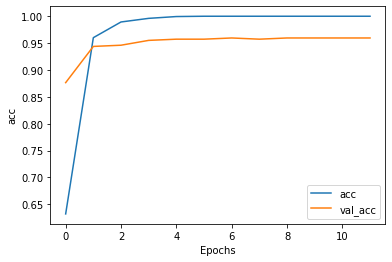

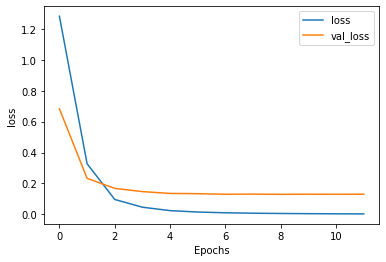

In [23]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "acc")
plot_graphs(history, "loss")

## Test the model

In [24]:
print(train_sentences[0])
print(index_label[training_label_seq[0][0]])
print(train_sentences[1])
print(index_label[training_label_seq[1][0]])

tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satellite  telecoms companies  broadband service providers front rooms portable devices.  one talked-about technologies ces digital personal video recorders (dvr pvr). set-top boxes  like us s tivo uk s sky+ system  allow people record  store  play  pause forward wind tv programmes want.  essentially  technology allows much personalised tv. also built-in high-definition tv sets  big business japan us  slower take off europe lack high-definition programming. not can people forward wind adverts  can also forget abiding network channel schedules  putting together a-la-carte entertainment. us 

In [25]:
sentences = ["finnan says irish can win group steve finnan believes the republic of ireland can qualify directly for the world cup finals.  after saturday s superb display in the draw in paris  ireland face minnows the faroe islands in dublin on wednesday. the ",
             train_sentences[0], 
             train_sentences[1]
             ]

test_sequences = tokenizer.texts_to_matrix(sentences)
#print(test_sequences)
r = model.predict_classes(test_sequences)

for u, v in list(zip(sentences, r)):
    print(f'{u}')
    print('→', index_label[v])

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
finnan says irish can win group steve finnan believes the republic of ireland can qualify directly for the world cup finals.  after saturday s superb display in the draw in paris  ireland face minnows the faroe islands in dublin on wednesday. the 
→ sport
tv future hands viewers home theatre systems  plasma high-definition tvs  digital video recorders moving living room  way people watch tv will radically different five years  time.  according expert panel gathered annual consumer electronics show las vegas discuss new technologies will impact one favourite pastimes. us leading trend  programmes content will delivered viewers via home networks  cable  satell

## auto-encoder model

In [0]:
input_seq = tf.keras.layers.Input(shape=(vocab_size))
encoded = tf.keras.layers.Dense(128, activation='relu')(input_seq)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)

decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(vocab_size, activation='sigmoid')(decoded)

In [34]:
encoder = Model(input_seq, encoded)
encoder.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
Total params: 138,464
Trainable params: 138,464
Non-trainable params: 0
_________________________________________________________________


In [37]:
autoencoder = Model(input_seq, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 1000)]            0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               128128    
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_15 (Dense)             (None, 64)                2112      
_________________________________________________________________
dense_16 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_17 (Dense)             (None, 1000)              1290

In [38]:
# fit model
num_epochs = 20
batch_size = 128
history = autoencoder.fit(train_sequences, train_sequences, 
                          epochs=num_epochs, batch_size=batch_size, shuffle=True, 
                          validation_data=(validation_sequences, validation_sequences))

Epoch 1/20
14/14 [==============================] - 0s 9ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 2/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 3/20
14/14 [==============================] - 0s 6ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 4/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 5/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6930
Epoch 6/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 7/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 8/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 9/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 10/20
14/14 [==============================] - 0s 5ms/step - loss: 0.6930 - val_loss: 0.6929
Epoch 11/20
14/14 [

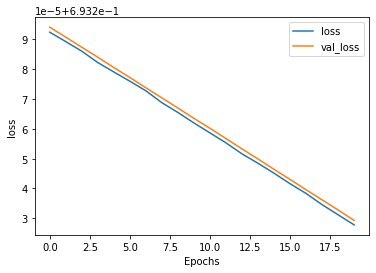

In [30]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "loss")

In [0]:
# encode and decode some digits
encoded_x = encoder.predict(validation_sequences)
decoded_x = autoencoder.predict(validation_sequences)

In [32]:
n = 10

print(validation_sequences.shape)
print(validation_sequences[n])
print(encoded_x[n].shape)
print(encoded_x[n])
print(decoded_x[n].shape)
print(decoded_x[n])

(445, 1000)
[0. 1. 1. 1. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 1. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0.
 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0.

## Utils

In [0]:
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.patches as mpatches

def plot_labelled_scatter(X, y, class_labels):
    num_labels = len(class_labels)

    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1

    marker_array = ['o', '^', '*']
    color_array = ['#FFFF00', '#0000FF', '#000000', '#FF0000', '#66FF66']
    cmap_bold = ListedColormap(color_array)
    bnorm = BoundaryNorm(np.arange(0, num_labels + 1, 1), ncolors=num_labels)
    plt.figure()

    plt.scatter(X[:, 0], X[:, 1], s=65, c=y, cmap=cmap_bold, norm = bnorm, alpha = 0.40, edgecolor='black', lw = 1)

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    h = []
    for c in range(0, num_labels):
        h.append(mpatches.Patch(color=color_array[c], label=class_labels[c]))
    plt.legend(handles=h)

    plt.xlabel('First principal component')
    plt.ylabel('Second principal component')
    plt.title('Dataset PCA (n_components = 2)')

    plt.show()

In [0]:
from sklearn.manifold import TSNE
tsne = TSNE(random_state = 0)
X_tsne = tsne.fit_transform(encoded_x)
plot_labelled_scatter(X_tsne, validation_label_seq, ['C1', 'C2','C3', 'C4', 'C5'])

ValueError: ignored

Reference https://machinelearningmastery.com/lstm-autoencoders/

In [0]:
# lstm autoencoder recreate sequence
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.utils import plot_model
# define input sequence
sequence = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
# reshape input into [samples, timesteps, features]
n_in = len(sequence)
sequence = sequence.reshape((1, n_in, 1))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_in,1)))
model.add(RepeatVector(n_in))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(sequence, sequence, epochs=300, verbose=0)
plot_model(model, show_shapes=True, to_file='reconstruct_lstm_autoencoder.png')
# demonstrate recreation
yhat = model.predict(sequence, verbose=0)
print(yhat[0,:,0])

[0.10548206 0.19961141 0.29803395 0.39854336 0.4997108  0.6006832
 0.7010243  0.80059636 0.8991729 ]
